In [19]:
import pandas as pd
from pandas_ods_reader import read_ods
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [4]:
def load_datasets(dirs: list) -> dict:
    file_names = ['flux_soc_out', 'atmosphere_out', 'n_flux_out', 'p_flux_out', 'soil_c_out', 'soil_water_out', 'surf_water_out', 'temp_out']
    datasets = {}
    for dr in dirs:
        path = 'datasets/' + dr + '/daily_data_merged'
        flux_soc = pd.read_csv(os.path.join(path, file_names[0] + '.csv'))
        atm = pd.read_csv(os.path.join(path, file_names[1] + '.csv'))
        nitrogen = pd.read_csv(os.path.join(path, file_names[2] + '.csv'))
        phosp = pd.read_csv(os.path.join(path, file_names[3] + '.csv'))
        soil_carbon = pd.read_csv(os.path.join(path, file_names[4] + '.csv'))
        soil_water = pd.read_csv(os.path.join(path, file_names[5] + '.csv'))
        surf_water = pd.read_csv(os.path.join(path, file_names[6] + '.csv'))
        temp = pd.read_csv(os.path.join(path, file_names[7] + '.csv'))

        flux_soc = flux_soc.drop(flux_soc.columns[0], axis=1)
        atm = atm.drop(atm.columns[0], axis=1)
        nitrogen = nitrogen.drop(nitrogen.columns[0], axis=1)
        phosp = phosp.drop(phosp.columns[0], axis=1)
        soil_carbon = soil_carbon.drop(soil_carbon.columns[0], axis=1)
        soil_water = soil_water.drop(soil_water.columns[0], axis=1)
        surf_water = surf_water.drop(surf_water.columns[0], axis=1)
        temp = temp.drop(temp.columns[0], axis=1)

        csv_list = [flux_soc, atm, nitrogen, phosp, soil_carbon, soil_water, surf_water, temp]

        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[file_names[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']
datasets = load_datasets(dirs)

In [5]:
irrigated_df = datasets['warm_temp_maize_soybean_irrigated']
x = pd.DataFrame()
for key in irrigated_df:
       x = x + irrigated_df[key]
        
y = irrigated_df['flux_soc_out']['CO2_FLUX']
x = x.drop(['CO2_FLUX' ,'DATE', 'unnamed.1'], axis=1)

CO2_FLUX LINEAR CORRELATED FEATURES

In [6]:
features = {
'ECO_NPP' : irrigated_df['flux_soc_out']['ECO_NPP'],
'ECO_GPP' : irrigated_df['flux_soc_out']['ECO_GPP'],
'NET_N_MIN' : irrigated_df['n_flux_out']['NET_N_MIN'],
'PRECN' : irrigated_df['soil_water_out']['PRECN'] ,
'NET_P_MIN' : irrigated_df['p_flux_out']['NET_P_MIN'] ,
'SUB_DOP_FLX' : irrigated_df['p_flux_out']['SUB_DOP_FLX'] ,
'ECO_RA' : irrigated_df['flux_soc_out']['ECO_RA'] ,
'N2_FLUX' : irrigated_df['n_flux_out']['N2_FLUX'] ,
'N2O_FLUX': irrigated_df['n_flux_out']['N2O_FLUX'] ,
}

x = pd.DataFrame(features)
y = irrigated_df['flux_soc_out']['CO2_FLUX']

NBP LINEAR CORRELATED FEATURES

In [115]:
nbp_feats = {
'ECO_NPP': irrigated_df['flux_soc_out']['ECO_NPP'],       
'ECO_GPP': irrigated_df['flux_soc_out']['ECO_GPP'],         
'NET_N_MIN': irrigated_df['n_flux_out']['NET_N_MIN'],      
'PRECN': irrigated_df['n_flux_out']['NET_N_MIN'],             
'NET_P_MIN': irrigated_df['p_flux_out']['NET_P_MIN'],      
'SUB_DOP_FLX': irrigated_df['p_flux_out']['SUB_DOP_FLX'],     
'ET': irrigated_df['soil_water_out']['ET'],
'DISCHG_SOIL': irrigated_df['soil_water_out']['DISCHG'],    
'DISCHG_SURF': irrigated_df['surf_water_out']['DISCHG'],    
'FERTZR_P':  irrigated_df['p_flux_out']['FERTZR_P'],          
'FERTZR_N':   irrigated_df['n_flux_out']['FERTZR_N'],           
'H2_FLUX':  irrigated_df['flux_soc_out']['H2_FLUX'],             
'NET_PL_EXCH_N':  irrigated_df['n_flux_out']['NET_PL_EXCH_N'],           
'N2O_FLUX': irrigated_df['n_flux_out']['N2O_FLUX'],
'N2_FLUX': irrigated_df['n_flux_out']['N2_FLUX'],
'ECO_RA': irrigated_df['flux_soc_out']['ECO_RA']
}

x = pd.DataFrame(nbp_feats)
y = irrigated_df['flux_soc_out']['NBP']

In [10]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
}

In [ ]:
# Instantiation
xgb = xg.XGBRegressor(learning_rate=0.02, objective ='reg:squarederror',
                 n_estimators=600, seed = 123)

folds = 3
param_comb = 5

kf = KFold(n_splits=folds, shuffle=True, random_state=123)

param_grid = {'max_depth': [3, 4, 5, 6, 7],
              'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
              'n_estimators': [100, 500, 1000, 2000]}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=4, cv=kf, verbose=3)

grid_search.fit(x, y)

In [ ]:
print('\n All results:')
print(grid_search.cv_results_)
print('\n Best estimator:')
print(grid_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [106]:
# Fitting the model
xgb_r.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [108]:
# Predict the model
pred = xgb_r.predict(test_X)
  

RMSE :  20.163214


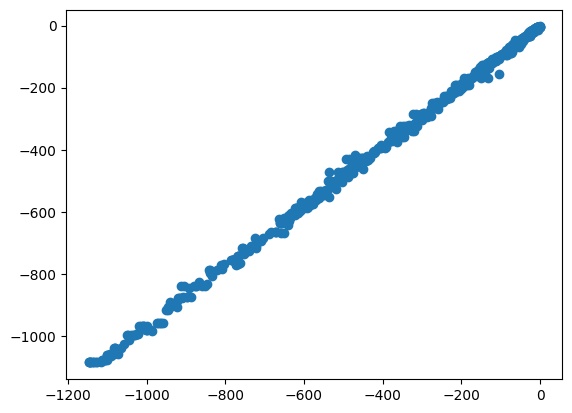

In [109]:
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))
plt.scatter(test_y, pred)

In [78]:
pd.DataFrame({'col_name': xgb_r.feature_importances_}, index=df.columns).sort_values(by='col_name', ascending=False)

,col_name
ACTV_LYR,0.0
SOC_13,0.0
SOC_8,0.0
SOC_7,0.0
SOC_6,0.0
...,...
ICE_3,0.0
ICE_20,0.0
ICE_2,0.0
ICE_19,0.0
